In [2]:
from exp_utils import *
import itertools
%matplotlib inline
device = torch.device('cuda')
logger = logging.getLogger(); logger.setLevel(logging.CRITICAL)
img_type = "pdf"

In [3]:
from exp_utils import est_alpha_one, levy_stable, np, pd

# Estimated Tail Index vs. Pruning Ratio according to Reconstruction Error

In [ ]:
import warnings
warnings.simplefilter("ignore")

x_types = ["x_final"]#["x_final", "x_mc"]#["x_final", "x_mc"]
assumptions = ["multivariate"]#["univariate", "multivariate"]
reconst_errors = [.1]#[.01, .05, .1, .15, .25, .5, .75, .95]


results_root_folder = f"results/{ef}/";
results_folder = ResultsFolder(results_root_folder)
df = pd.read_csv(results_folder.results_summary_folder + results_folder.timestamp + f"_x_mc_results.csv")
for assumption in assumptions:
    for x_type in x_types:
        print(ef, assumption, x_type)
        layer_cols = [f for f  in  df.columns if (f"alpha_hat{'_ind' if assumption == 'univariate' else '_layer'}_" in f)]
        dfp = df[["folder", "lr_b"] + layer_cols] 
        dfp["reconst_error"] = np.nan
        dfp = pd.concat([dfp.fillna({"reconst_error":reconst_error}) for reconst_error in reconst_errors])
        dfp["pruned_parameter_ratio"] = np.nan
        dfp = dfp.melt(id_vars=['folder', 'lr_b', 'reconst_error', 'pruned_parameter_ratio'],value_vars=layer_cols, var_name="layer_no", value_name="alpha_hat")
        dfp["layer_no"] = dfp.layer_no.str[-1].astype(int)
        #dfp_ind = dfp.copy()
        #dfp_ell = dfp.copy()
        for folder in results_folder.folders:
            print(folder)
            if len(dfp.loc[dfp.folder == clean_folder(folder) ]) < 1:
                print("skipping due to missing alpha estimations")
                continue
            model, args, model_name, dataset_name, layers, no_layers = get_model_info(folder, dream_team=True, x_type=x_type)
            for reconst_error in reconst_errors:
                with torch.no_grad():
                    for pi, p in enumerate(layers):
                        a = get_layer_to_numpy(p).copy(); assert len(a.shape) in AVAILABLE_PARAMS
                        a_flat = a.flatten()
                        a_median = np.median(a_flat)
                        a_flat -= a_median
                        idx = int((percentileofscore(np.sqrt(np.cumsum(np.sort(np.abs(a_flat)) ** 2))/np.linalg.norm(a_flat), reconst_error)/100)*len(a_flat))
                        assert len(dfp.loc[(dfp.folder == clean_folder(folder) ) & (dfp.reconst_error == reconst_error) & (dfp.layer_no == pi)]) == 1
                        dfp.loc[(dfp.folder == clean_folder(folder) ) & (dfp.reconst_error == reconst_error) & (dfp.layer_no == pi), "pruned_parameter_ratio"] = idx/len(a_flat)

                        #alpha_hat = dfp.loc[(dfp.folder == clean_folder(folder) ) & (dfp.reconst_error == reconst_error) & (dfp.layer_no == pi), "alpha_hat"].iloc[0]
                        #alpha_hat = min(alpha_hat, 1.999)

                        #a_ind = levy_stable.rvs(alpha=alpha_hat, beta=0, size=1000000)
                        #idx = int((percentileofscore(np.sqrt(np.cumsum(np.sort(np.abs(a_ind)) ** 2))/np.linalg.norm(a_ind), reconst_error)/100)*len(a_ind))
                        #dfp_ind.loc[(dfp_ind.folder == clean_folder(folder) ) & (dfp_ind.reconst_error == reconst_error) & (dfp_ind.layer_no == pi), "pruned_parameter_ratio"] = idx/len(a_ind)

                        #a_ell = simulate_mv_stable(1000, 1000, alp=alpha_hat, elliptic=True).flatten()
                        #idx = int((percentileofscore(np.sqrt(np.cumsum(np.sort(np.abs(a_ell)) ** 2))/np.linalg.norm(a_ell), reconst_error)/100)*len(a_ell))
                        #dfp_ell.loc[(dfp_ell.folder == clean_folder(folder) ) & (dfp_ell.reconst_error == reconst_error) & (dfp_ell.layer_no == pi), "pruned_parameter_ratio"] = idx/len(a_ell)
        dfp.to_csv(results_folder.results_summary_folder + f"{results_folder.timestamp}_{x_type}_{assumption}_tail_index_vs_pruning_ratio.csv", index=False)
        #dfp_ind.to_csv(results_folder.results_summary_folder + f"{results_folder.timestamp}_{x_type}_{assumption}_ind_tail_index_vs_pruning_ratio.csv", index=False)
        #dfp_ell.to_csv(results_folder.results_summary_folder + f"{results_folder.timestamp}_{x_type}_{assumption}_ell_tail_index_vs_pruning_ratio.csv", index=False)

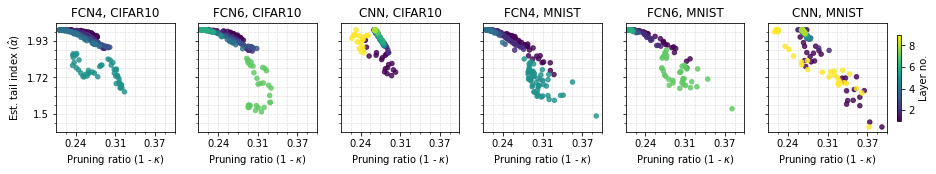

In [84]:
#%matplotlib agg
reconst_error = .1
for suffix in [""]:#, "ind", "ell"
    for assumption in assumptions:
        for x_type in x_types:
            I = 1; J = len(EF) // I if len(EF) % I == 0 else len(EF) // I + 1; J = 2 if J == 1 else J
            fig, axes = plt.subplots(I,J,figsize=(2.25*J,2*I), sharex=True, sharey=True)
            
            alpha_hat_min, alpha_hat_max = 2, 0
            ppr_min, ppr_max = 1, 0
            
            limits = (1, 9); nValues = np.linspace(limits[0], limits[1], 9); 
            normalize = mcolors.Normalize(vmin=limits[0], vmax=limits[1]); scalarmappaple = cm.ScalarMappable(norm=normalize); scalarmappaple.set_array(nValues); colormap = cm.viridis
            for ei, ef in enumerate(EF):
                if ei == 3:
                    continue
                results_root_folder = f"results/{ef}/"; img_type = "pdf"
                results_folder = ResultsFolder(results_root_folder)
                dfp = pd.read_csv(results_folder.results_summary_folder + f"{results_folder.timestamp}_{x_type}_{assumption}_{suffix + '_' if suffix != '' else ''}tail_index_vs_pruning_ratio.csv")
                dfp = dfp.query(f"reconst_error == {reconst_error}")
                dfp_re = dfp
                
                alpha_hat_min, alpha_hat_max = min(dfp_re["alpha_hat"].min(), alpha_hat_min), max(dfp_re["alpha_hat"].max(), alpha_hat_max)
                ppr_min, ppr_max = min(dfp_re["pruned_parameter_ratio"].min(), ppr_min), max(dfp_re["pruned_parameter_ratio"].max(), ppr_max)
            
            alpha_hat_min, alpha_hat_max = alpha_hat_min*.98, alpha_hat_max*1.02
            ppr_min, ppr_max = ppr_min*.98, ppr_max*1.02
            for ei, ef in enumerate(EF):
                i, j = ei // J , ei % J 
                ax = axes[i, j] if I > 1 else axes[ei]
                
                results_root_folder = f"results/{ef}/"; img_type = "pdf"
                results_folder = ResultsFolder(results_root_folder)

                dfp = pd.read_csv(results_folder.results_summary_folder + f"{results_folder.timestamp}_{x_type}_{assumption}_{suffix + '_' if suffix != '' else ''}tail_index_vs_pruning_ratio.csv")
                dfp = dfp.query(f"reconst_error == {reconst_error}")
                dfp_re = dfp
                

                
                ax.scatter(dfp_re["pruned_parameter_ratio"], dfp_re["alpha_hat"], c=[colormap(normalize(nValues[li])) for li in dfp_re["layer_no"]], cmap = matplotlib.cm.viridis_r, s=20, alpha=.8)#,  norm=matplotlib.colors.LogNorm())
                
                ax.set_xlim(ppr_min, ppr_max)
                ax.set_ylim(alpha_hat_min, alpha_hat_max)
                yticks = np.linspace(alpha_hat_min, alpha_hat_max, 7)[1:-1:2]
                ax.set_yticks(yticks)
                ax.set_yticklabels(np.round(yticks, 2))
                xticks = np.linspace(ppr_min, ppr_max, 7)[1:-1:2]
                ax.set_xticks(xticks)
                ax.set_xticklabels(np.round(xticks, 2))
                
                ax.set_ylabel("Est. tail index ($\\hat{\\alpha}$)") if ei == 0 else None
                ax.set_xlabel("Pruning ratio (1 - $\\kappa)$")
                
                ax.set_axisbelow(True)
                ax.minorticks_on()
                ax.grid(which='major', linestyle=':', linewidth='0.5')
                ax.grid(which='minor', linestyle=':', linewidth='0.5')
                if 'fcn' in results_folder.model_name.lower():
                    try:
                        if 'large' in ef:
                            s = '6'
                        else:
                            s = '4'
                    except:
                        s = ''
                else:
                    s = ''
                ax.set_title(f"{results_folder.model_name.lower().replace('vgg11_bw', 'CNN').replace('vgg11', 'CNN').upper()}{s}, {results_folder.dataset_name.upper()}")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        #fig.tight_layout() 
        
    _ = fig.subplots_adjust(right=0.98, wspace=.2)
    cbar_ax = fig.add_axes([0.99, 0.2, 0.005, 0.6]) 
    fig.colorbar(scalarmappaple, ticks=[2,4,6,8],  orientation="vertical", cax=cbar_ax, label="Layer no.")#, label="$\\eta / b$")
    
    fig.savefig(f"results/img/alpha_hat_vs_kappa_{x_type}_{assumption}_{suffix + '_' if suffix != '' else ''}tail_index_vs_pruning_ratio."+ img_type, format=img_type, bbox_inches='tight')
#%matplotlib inline

# Estimated Tail Index vs. Pruning Ratio according to Reconstruction Error with Synthetic Data

In [125]:
np.random.seed(0)
reconst_error = .1
no_reps = 250
alphas = np.random.uniform(1.75, 2., no_reps)
N = 250000
d = 500
dfp_ind = pd.DataFrame(index=range(no_reps), columns=["alpha", "pruned_parameter_ratio"])
dfp_ind["alpha"] = alphas
dfp_ell = dfp_ind.copy()
dfp_all = dfp_ind.copy()

for ai, alpha in enumerate(alphas):
    a_ind = levy_stable.rvs(alpha=alpha, beta=0, size=N)
    idx = int((percentileofscore(np.sqrt(np.cumsum(np.sort(np.abs(a_ind)) ** 2))/np.linalg.norm(a_ind), reconst_error)/100)*len(a_ind))
    dfp_ind.loc[ai, "pruned_parameter_ratio"] = idx/len(a_ind)

    a_ell = simulate_mv_stable(d, N//d, alp=alpha, elliptic=True).flatten()
    idx = int((percentileofscore(np.sqrt(np.cumsum(np.sort(np.abs(a_ell)) ** 2))/np.linalg.norm(a_ell), reconst_error)/100)*len(a_ell))
    dfp_ell.loc[ai, "pruned_parameter_ratio"] = idx/len(a_ell)
    
    a_all = simulate_mv_stable(N, 1, alp=alpha, elliptic=True).flatten()
    idx = int((percentileofscore(np.sqrt(np.cumsum(np.sort(np.abs(a_all)) ** 2))/np.linalg.norm(a_all), reconst_error)/100)*len(a_all))
    dfp_all.loc[ai, "pruned_parameter_ratio"] = idx/len(a_all)

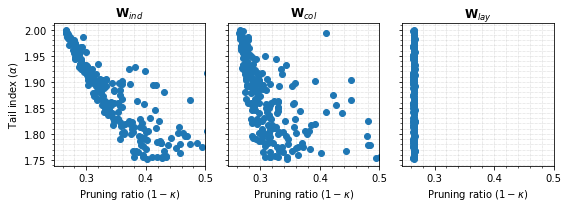

In [133]:
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(8, 3))
axes[0].scatter(dfp_ind.pruned_parameter_ratio, dfp_ind.alpha)
axes[0].set_xlabel("Pruning ratio $(1 - \\kappa)$")
axes[0].set_ylabel("Tail index ($\\alpha$)")
axes[0].set_title("$\\mathbf{W}_{ind}$")

axes[1].scatter(dfp_ell.pruned_parameter_ratio, dfp_ell.alpha)
axes[1].set_title("Column-wise elliptical")
axes[1].set_xlabel("Pruning ratio $(1 - \\kappa)$")
axes[1].set_title("$\\mathbf{W}_{col}$")

axes[2].scatter(dfp_all.pruned_parameter_ratio, dfp_ell.alpha)
axes[2].set_title("Layer-wise elliptical")
axes[2].set_xlabel("Pruning ratio $(1 - \\kappa)$")
axes[2].set_title("$\\mathbf{W}_{lay}$")
axes[2].set_xlim(0.245, .5);
#fig.suptitle("Reconstruction error $= .1$")

axes[0].set_axisbelow(True)
axes[0].minorticks_on()
axes[0].grid(which='major', linestyle=':', linewidth='0.5')
axes[0].grid(which='minor', linestyle=':', linewidth='0.5')

axes[1].set_axisbelow(True)
axes[1].minorticks_on()
axes[1].grid(which='major', linestyle=':', linewidth='0.5')
axes[1].grid(which='minor', linestyle=':', linewidth='0.5')

axes[2].set_axisbelow(True)
axes[2].minorticks_on()
axes[2].grid(which='major', linestyle=':', linewidth='0.5')
axes[2].grid(which='minor', linestyle=':', linewidth='0.5')

fig.tight_layout()
fig.savefig(f"results/img/synth_alpha_vs_pruning_ratio."+ img_type, format=img_type, bbox_inches='tight')